## Partition Function in Portfolio Construction 

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from itertools import combinations_with_replacement 
import cvxpy as cp

(CVXPY) Dec 27 11:50:47 AM: Encountered unexpected exception importing solver CVXOPT:
ImportError('DLL load failed while importing base: Le module spécifié est introuvable.')
(CVXPY) Dec 27 11:50:47 AM: Encountered unexpected exception importing solver GLPK:
ImportError('DLL load failed while importing base: Le module spécifié est introuvable.')
(CVXPY) Dec 27 11:50:47 AM: Encountered unexpected exception importing solver GLPK_MI:
ImportError('DLL load failed while importing base: Le module spécifié est introuvable.')


In [3]:
def fetch_stock_yfinance(tickers, start_date, end_date):
    """
    Fetch daily adjusted close prices for a list of tickers from Yahoo Finance.
    """
    data = yf.download(tickers, start=start_date, end=end_date)["Adj Close"]
    return data.pct_change().dropna()

In [4]:
def generate_partitions(n,k):
    """Generate some partitions of integer n into k parts.
    """
    for c in combinations_with_replacement(range(n+1),k):
        if sum(c) == n:
            yield np.array(c) / n 

In [34]:
def evaluate_partitions(partitions, returns, cov_matrix, risk_tolerance):
    """
    Evaluate portfolios based on a set of partitions that create the weights.
    """
    best_portfolio = None
    best_return = -np.inf

    for weights in partitions:
        expected_return = weights @ np.mean(returns, axis=0)
        risk = weights.T @ cov_matrix @ weights
        utility = expected_return - risk_tolerance * risk
        if utility > best_return:
            best_return = utility
            best_portfolio = weights
    portfolio_variance = best_portfolio.T @ cov_matrix @ best_portfolio
    return best_portfolio, best_return, portfolio_variance

In [36]:
def optimization_portfolio(returns, cov_matrix, risk_tolerance):
    """
    Optimize the portfolio weights using quadratic programming (Mean-Variance Optimization).
    """
    mean_returns = np.mean(returns, axis=0)  # Average returns (1D array of size n_assets)
    n = len(mean_returns)  # Number of assets
    w = cp.Variable(n)
    utility = mean_returns @ w
    constraints = [w.T @ cov_matrix @ w <= risk_tolerance,  # Risk constraint (variance)
                cp.sum(w) == 1,
                w >= 0]
    problem = cp.Problem(cp.Maximize(utility), constraints)
    result = problem.solve()
    portfolio_variance = w.T @ cov_matrix @ w  # Portfolio variance
    return w.value, result, portfolio_variance.value

In [45]:
tickers = ["AAPL", "MC.PA", "AI.PA", "NVDA", "DG.PA"] # Apple, LVMH, Air Liquide, Nvidia, Vinci
start_date = "2023-01-01"
end_date = "2023-12-31"
future_start_date = "2024-01-01"
future_end_date = "2024-12-31"
risk_tolerance = 1

returns = fetch_stock_yfinance(tickers, start_date, end_date).values
future_returns = fetch_stock_yfinance(tickers, future_start_date, future_end_date)

cov_matrix = np.cov(returns, rowvar = False)
nb_partitions = 100
partitions = list(generate_partitions(nb_partitions, len(tickers)))

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed


In [48]:
optimal_weights_partition, optimal_return_partition, optimal_risk_partition = evaluate_partitions(partitions, returns, cov_matrix, risk_tolerance)

optimal_weights_MV, optimal_return_MV, optimal_risk_MV  = optimization_portfolio(returns, cov_matrix, risk_tolerance)

print("Using Partitions:\n")
print(f"Optimal Weights: {optimal_weights_partition}")
print(f"Optimal Return: {optimal_return_partition}")
print(f"Risk associated to the Optimal portfolio: {optimal_risk_partition}\n")
print("Using Markowitz theory:\n")
print(f"Optimal Weights: {optimal_weights_MV}")
print(f"Optimal Return: {optimal_return_MV}")
print(f"Risk associated to the Optimal portfolio: {optimal_risk_MV}")

Using Partitions:

Optimal Weights: [0. 0. 0. 0. 1.]
Optimal Return: 0.0043860232681887015
Risk associated to the Optimal portfolio: 0.0009069759783314611

Using Markowitz theory:

Optimal Weights: [3.45236924e-08 1.37289751e-08 1.31668530e-08 1.29690963e-08
 9.99999926e-01]
Optimal Return: 0.00529299894713947
Risk associated to the Optimal portfolio: 0.0009069758595477774


In [49]:
partition_portfolio_return = (future_returns @ optimal_weights_partition).cumsum()
MV_portfolio_return = (future_returns @ optimal_weights_MV).cumsum()

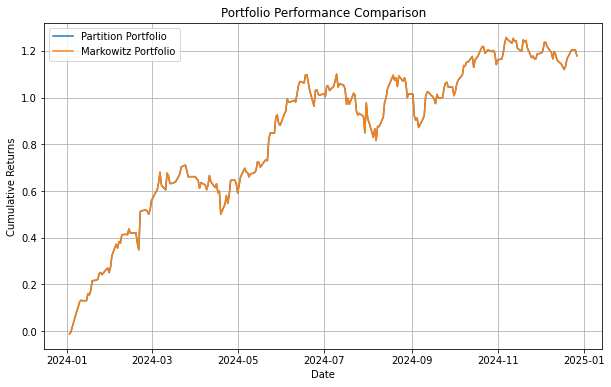

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(future_returns.index, partition_portfolio_return, label="Partition Portfolio")
plt.plot(future_returns.index, MV_portfolio_return, label="Markowitz Portfolio")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Portfolio Performance Comparison")
plt.legend()
plt.grid()
plt.show()